# Model Evaluation
The following notebook performs measures various metrics involving the models against the provided ground-truth data.
This notebook is meant to be used as a prototype workbench for developing core code for model performance evaluation and comparison.

In our evaluation pipeline, we closely follow the result analysis performed by Gabere et. al.

In [191]:
import math
import numpy as np
import seaborn as sns
import modin.pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

In [192]:
# Application Hyperparameters
DATA_ROOT = '../data/out/data.fasta.txt/'
SERVERS = ['ADAM_HMM', 'ADAM_SVM', 'AMPA', 'CAMPR3-ANN', 'CAMPR3-DA', 'CAMPR3-RF', 'CAMPR3-SVM']
DATA_DIR = DATA_ROOT + 'CAMPR3-SVM.csv'

## Load Dataset

In [193]:
data = {}
for s in SERVERS:
    data[s] = pd.read_csv(DATA_ROOT + s + '.csv')
    print(s + ' : ' + str(data[s].size) + ' RECORDS')

ADAM_HMM : 81354 RECORDS
ADAM_SVM : 81354 RECORDS
AMPA : 81354 RECORDS
CAMPR3-ANN : 81354 RECORDS
CAMPR3-DA : 81354 RECORDS
CAMPR3-RF : 81354 RECORDS
CAMPR3-SVM : 81354 RECORDS


In [194]:
# Filter -999 Values
for s in SERVERS:
    data[s] = data[s].query('PredLabel != -999')
    print(s + ' (POST-FILTERED): ' + str(data[s].size) + ' RECORDS')

ADAM_HMM (POST-FILTERED): 81192 RECORDS


/usr/local/lib/python3.6/dist-packages/modin/pandas/dataframe.py:2901: UserWarning: User-defined function verification with DataFrame dtypes is still under development. Should be fully functional in a future release.
  UserWarning,


ADAM_SVM (POST-FILTERED): 81144 RECORDS
AMPA (POST-FILTERED): 81138 RECORDS
CAMPR3-ANN (POST-FILTERED): 81240 RECORDS
CAMPR3-DA (POST-FILTERED): 81240 RECORDS
CAMPR3-RF (POST-FILTERED): 81054 RECORDS
CAMPR3-SVM (POST-FILTERED): 81240 RECORDS


## Threshold Based Metrics

### Confusion Matrix

In [195]:
for s in SERVERS:
    print('[' + s + ']')
    con_mat = confusion_matrix(data[s]['AMPLabel'], data[s]['PredLabel'])
    print(str(con_mat) + '\n')
    print('True Positive:\t' + str(con_mat[0][0]))
    print('False Positive:\t' + str(con_mat[0][1]))
    print('False Negative:\t' + str(con_mat[1][0]))
    print('True Negative:\t' + str(con_mat[1][1]))
    print('='* 40)

[ADAM_HMM]
[[7225 4063]
 [ 269 1975]]

True Positive:	7225
False Positive:	4063
False Negative:	269
True Negative:	1975
[ADAM_SVM]
[[7200 4079]
 [ 270 1975]]

True Positive:	7200
False Positive:	4079
False Negative:	270
True Negative:	1975
[AMPA]
[[10049  1229]
 [ 1385   860]]

True Positive:	10049
False Positive:	1229
False Negative:	1385
True Negative:	860
[CAMPR3-ANN]
[[9345 1946]
 [ 393 1856]]

True Positive:	9345
False Positive:	1946
False Negative:	393
True Negative:	1856
[CAMPR3-DA]
[[8871 2420]
 [ 273 1976]]

True Positive:	8871
False Positive:	2420
False Negative:	273
True Negative:	1976
[CAMPR3-RF]
[[9114 2146]
 [ 120 2129]]

True Positive:	9114
False Positive:	2146
False Negative:	120
True Negative:	2129
[CAMPR3-SVM]
[[8882 2409]
 [ 199 2050]]

True Positive:	8882
False Positive:	2409
False Negative:	199
True Negative:	2050


In [196]:
print('Classification Report')

for s in SERVERS:
    print('['+s+']')
    print(classification_report(data[s]['AMPLabel'], data[s]['PredLabel'], [0, 1]))
    print('='*40)

Classification Report
[ADAM_HMM]
              precision    recall  f1-score   support

           0       0.96      0.64      0.77     11288
           1       0.33      0.88      0.48      2244

   micro avg       0.68      0.68      0.68     13532
   macro avg       0.65      0.76      0.62     13532
weighted avg       0.86      0.68      0.72     13532

[ADAM_SVM]
              precision    recall  f1-score   support

           0       0.96      0.64      0.77     11279
           1       0.33      0.88      0.48      2245

   micro avg       0.68      0.68      0.68     13524
   macro avg       0.65      0.76      0.62     13524
weighted avg       0.86      0.68      0.72     13524

[AMPA]
              precision    recall  f1-score   support

           0       0.88      0.89      0.88     11278
           1       0.41      0.38      0.40      2245

   micro avg       0.81      0.81      0.81     13523
   macro avg       0.65      0.64      0.64     13523
weighted avg       0.80

### ROC/AUC Curve

#### Total ROC/AUC Score

In [197]:
for s in SERVERS:
    print(s + ' SCORE:\t'+str(roc_auc_score(data[s]['AMPLabel'], data[s]['PredScore'])))

ADAM_HMM SCORE:	0.760092509073728
ADAM_SVM SCORE:	0.7590436017345834
AMPA SCORE:	0.6427427148900574
CAMPR3-ANN SCORE:	0.8264530050829231
CAMPR3-DA SCORE:	0.8827895404088115
CAMPR3-RF SCORE:	0.9397764706161097
CAMPR3-SVM SCORE:	0.8968369767978439


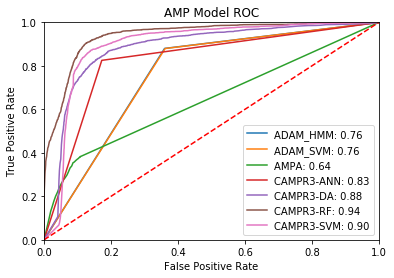

In [198]:
# Plot ROC/AUC

plt.title('AMP Model ROC')

for s in SERVERS:
    fpr, tpr, threshold = roc_curve(data[s]['AMPLabel'], data[s]['PredScore'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = s + ': %0.2f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Feature Dependence Analysis

### Length vs Prediction Probability

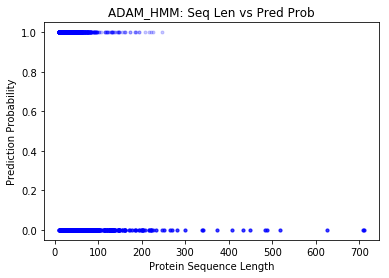

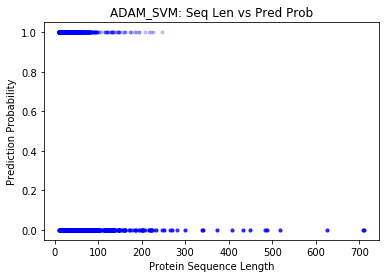

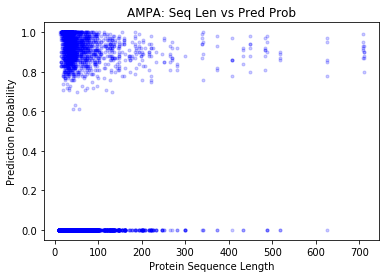

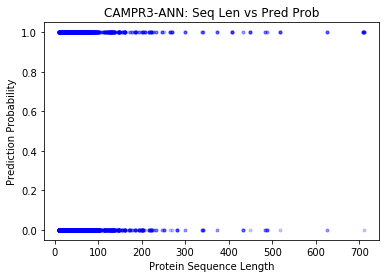

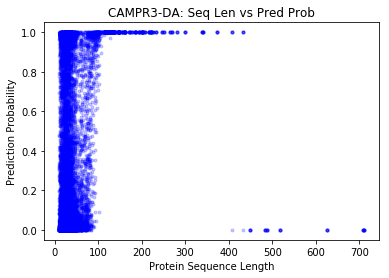

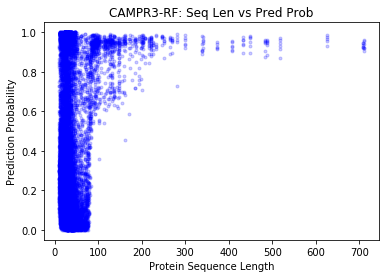

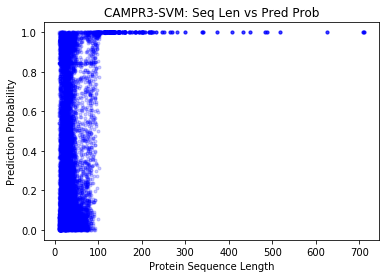

In [199]:
for s in SERVERS:
    plt.title(s + ': Seq Len vs Pred Prob')
    plt.plot(data[s]['PepSeq'].apply(len), data[s]['PredScore'], 'b.', alpha=0.2)
    plt.xlabel('Protein Sequence Length')
    plt.ylabel('Prediction Probability')
    plt.show()

### Number of Unique Protein Count vs Prediction Probability

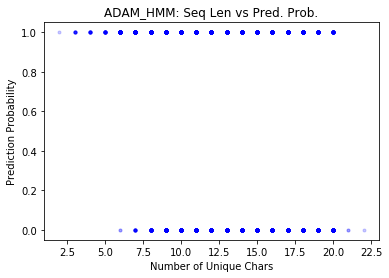

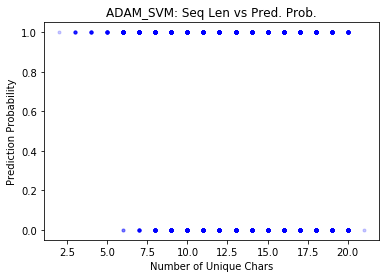

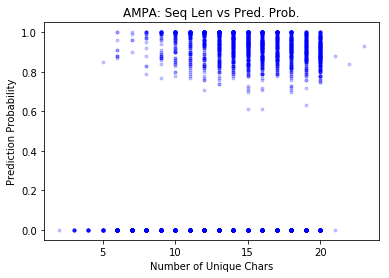

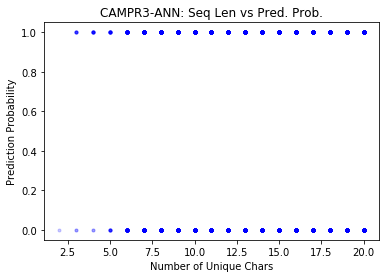

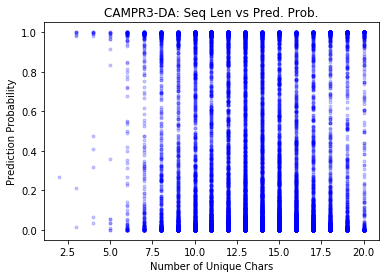

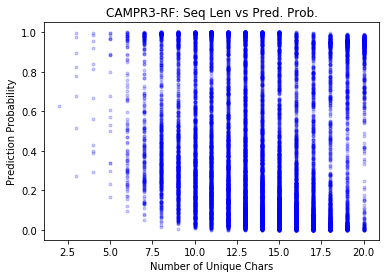

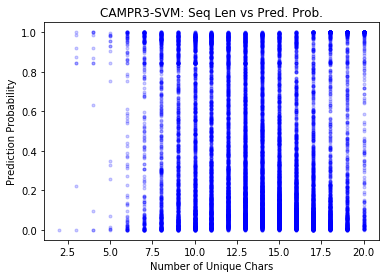

In [200]:
for s in SERVERS:
    plt.title(s + ': Seq Len vs Pred. Prob.')
    plt.plot(data[s]['PepSeq'].apply(lambda x: len(set(x))), data[s]['PredScore'], 'b.', alpha=0.2)
    plt.xlabel('Number of Unique Chars')
    plt.ylabel('Prediction Probability')
    plt.show()